## Setup, Loading Data and CDFs

In [76]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True

In [77]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
CWD = os.getcwd()
from reporting import *
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "final_plots", "results", "fit_categorization")
np.random.seed(0)

# Actually Pass

Name the notebook:
green_diagonal_wavelet_full_agriVision.ipynb


Name the notebook:
green_diagonal_wavelet_full_agriVision.ipynb
-238.61386 255.76952
-5.21


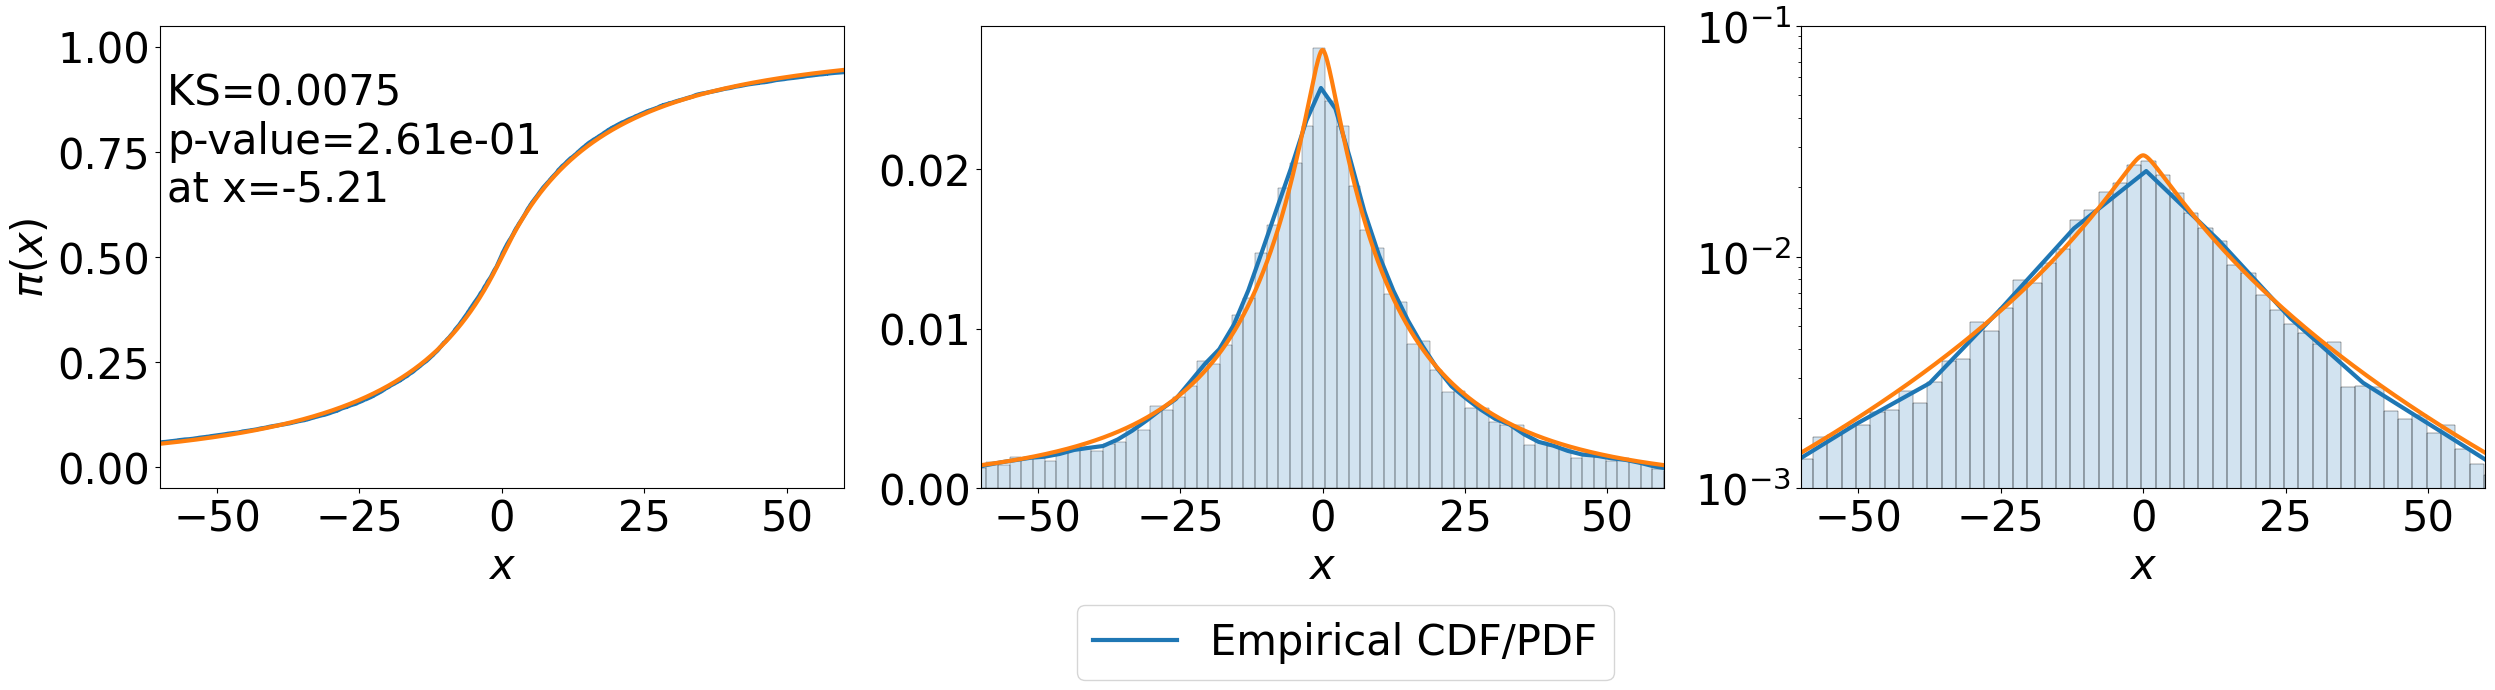

In [116]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'green'

r1, eta1, scale1 = 0.09, 1.9, 1.743e-15
group = 3
n_samples = 5000


path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))


sample = group_data_map[3]
sample_size = group_total_samples[3]

params1 = (r1, eta1, scale1)
log_scale = True


distro='gengamma'
log_scale=True
n_samples=5000
interval=None
provided_loc=None
group=None
percent_excluded=0.1
plot_hist=True
bw=0.05
bw_log=0.05
binwidth=None
sample = sample 
fontsize=30
linewidth=3

def compute_cdf_pdf(params):
    if distro == 'gengamma':
        if len(params) == 3:
            r, eta, scale = params
        else:
            r, eta = params
            scale = 1
        xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale=scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
        null_pdf = null_cdf.derivative()(xs_pdf)
    elif distro == 'gaussian' or distro == 'normal':
        null_cdf = stats.norm(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.norm(scale=params).pdf(xs_pdf)
    elif distro == 'laplace':
        null_cdf = stats.laplace(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.laplace(scale=params).pdf(xs_pdf)
    return xs_pdf, null_cdf, null_pdf

xs_pdf1, null_cdf1, null_pdf1 = compute_cdf_pdf(params1)


if len(sample) > 0:
    lower_bound = np.percentile(sample, percent_excluded / 2)
    upper_bound = np.percentile(sample, 100 - percent_excluded / 2)
    original_sample = sample
    sample = sample[(sample > lower_bound) & (sample < upper_bound)]
    sample = np.sort(sample)
    n = len(sample)
    if interval is None:
        interval = (np.percentile(sample, 0.5), np.percentile(sample, 99.5))
    xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 20000000)
    print(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]))

if log_scale:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))

    if interval:
        ax1.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        ax1.plot(sample, np.arange(1, n + 1) / n, label='Empirical CDF/PDF', linewidth=linewidth)
        result1 = stats.ks_1samp(original_sample, null_cdf1)
        distance1, location1 = result1.statistic, np.round(result1.statistic_location, 2)
    
        #paramtext1 = rf"$r={params1[0]}, \eta={params1[1]}, \vartheta={np.format_float_scientific(params1[2], precision=2)}$"
        pvalue = stats.kstwo.sf(distance1, sample_size)
        location1 = round(float(location1), 2)
        ax1.text(
            0.01, 0.9, 
            f"KS={np.round(distance1, 4)} \np-value={np.format_float_scientific(pvalue, precision=2)}\nat x={location1} ", 
            transform=ax1.transAxes, 
            fontsize=fontsize, 
            verticalalignment='top', 
            horizontalalignment='left'
        )
        
        print(location1)
        ax1.plot(xs, null_cdf1(xs),  linewidth=linewidth)

    if interval:
        ax2.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method=bw, ax=ax2, label=f'Empirical PDF (KDE, bw={bw})', linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax2, binwidth=binwidth, stat='density', label=f'Empirical PDF ({100 - percent_excluded}% of sample)', alpha=0.2)
    ax2.plot(xs_pdf1, null_pdf1, label='Computed PDF (params1)', linewidth=linewidth)


    if interval:
        ax3.set_xlim(left=interval[0], right=interval[1])
    ax3.set_ylim(bottom=10**-3, top=0.1)

    if len(sample) > 0:
        sns.kdeplot(ax=ax3, x=sample, bw_method=bw_log, log_scale=[False, True], label=f"Empirical PDF (KDE, bw={bw_log})", linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax3, binwidth=binwidth, stat="density", log=True, bins=1000, alpha=0.2, color='#1f77b4', label=f'Empirical PDF ({100 - percent_excluded}% of sample)')

    ax3.plot(xs_pdf1, null_pdf1, label="Computed PDF (params1)", linewidth=linewidth)

    # Move legend outside the plot and make it common for all subplots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, -0.05), ncol=4, fontsize=fontsize, markerscale=50)

    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=fontsize)
    ax3.tick_params(axis='both', which='major', labelsize=fontsize)

    ax1.set_ylabel(r"$\pi(x)$", fontsize=fontsize)
    ax2.set_ylabel("")
    ax3.set_ylabel("")

    ax1.set_xlabel(r"$x$", fontsize=fontsize)
    ax2.set_xlabel(r"$x$", fontsize=fontsize)
    ax3.set_xlabel(r"$x$", fontsize=fontsize)

    ax1.set_xlim((-60, 60))
    ax2.set_xlim((-60, 60))
    ax3.set_xlim((-60, 60))

    #plt.tight_layout()

    if SAVE_FIGS:
        save_path = os.path.join(plots_path, "actually_pass.jpg")
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')

    plt.show()






# Practically Pass

Name the notebook:
blue_diagonal_wavelet_full_segmentAnything.ipynb
-0.7598123 0.7601726
-0.0


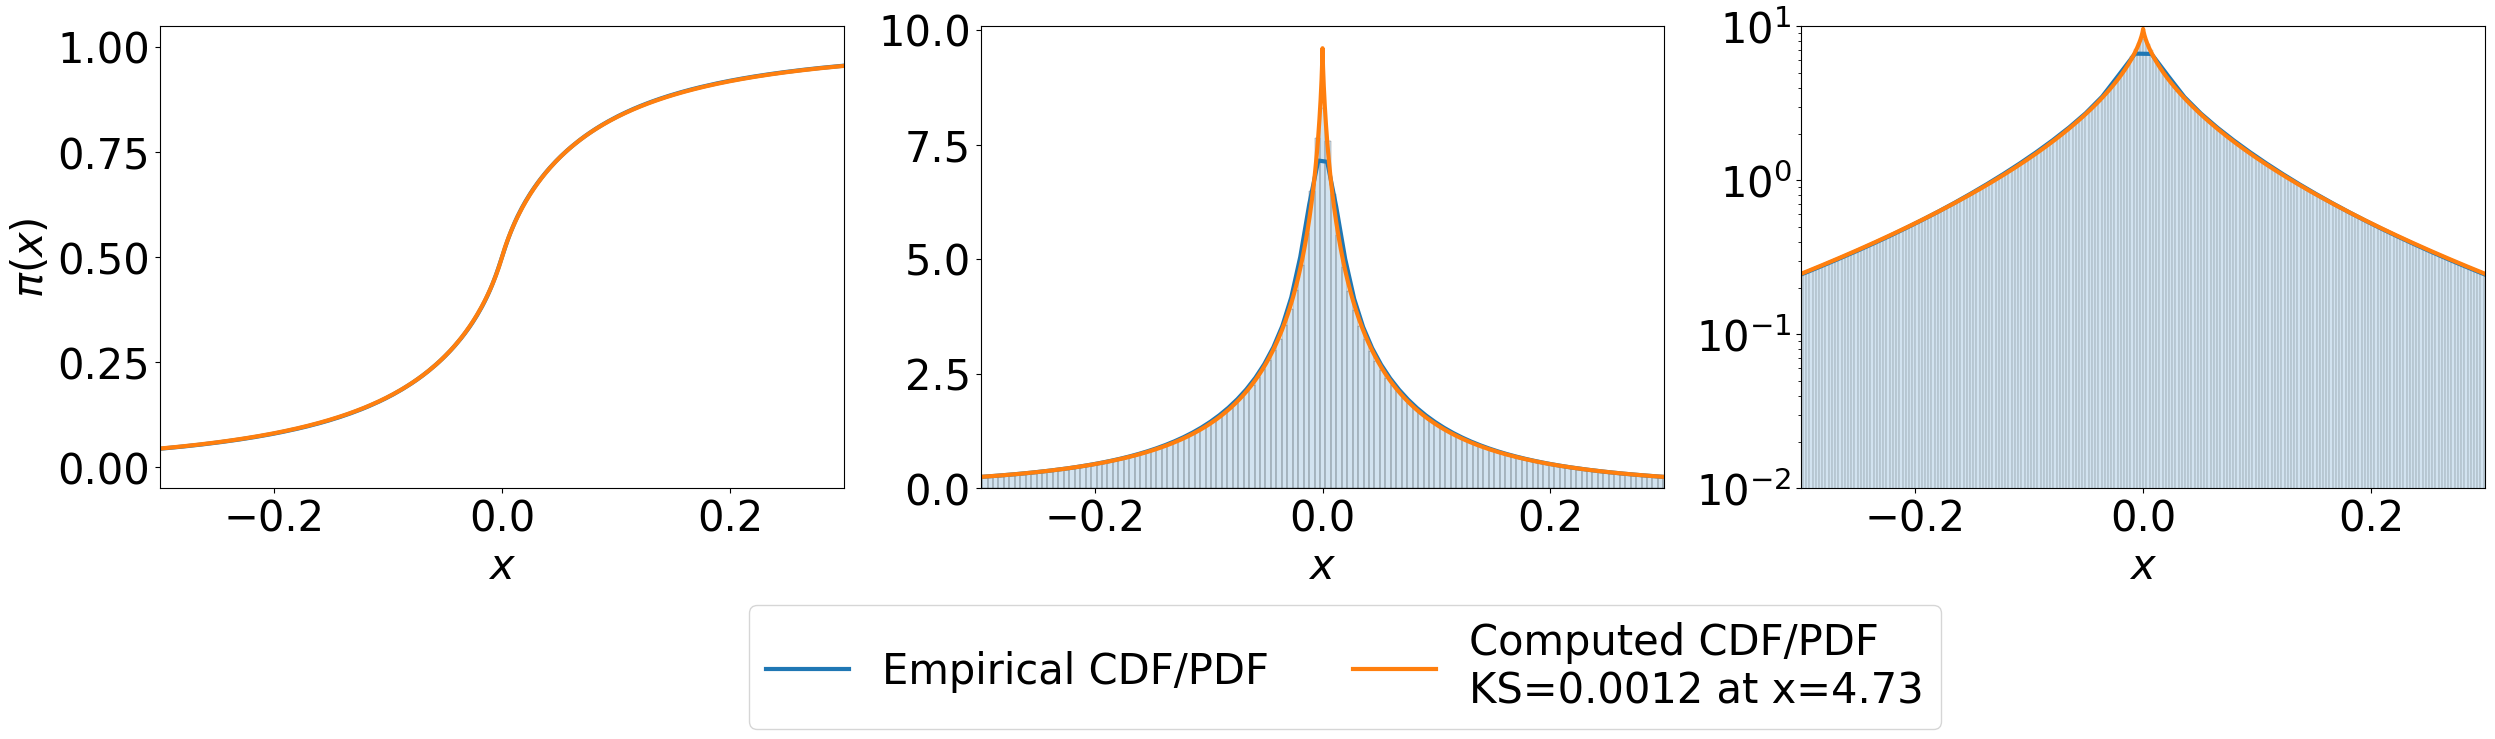

In [82]:
DATA_NAME = 'segmentAnything-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'blue'

r1, eta1, scale1 = 0.29, -0.6, 2.792e-4
n_samples = 5000
group = 10


path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))
sample = group_data_map[group]

params1 = (r1, eta1, scale1)
log_scale = True


distro='gengamma'
log_scale=True
n_samples=5000
interval=None
provided_loc=None
group=None
percent_excluded=0.1
plot_hist=True
bw=0.05
bw_log=0.05
binwidth=None
sample = sample 
fontsize=30
linewidth=3

def compute_cdf_pdf(params):
    if distro == 'gengamma':
        if len(params) == 3:
            r, eta, scale = params
        else:
            r, eta = params
            scale = 1
        xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale=scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
        null_pdf = null_cdf.derivative()(xs_pdf)
    elif distro == 'gaussian' or distro == 'normal':
        null_cdf = stats.norm(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.norm(scale=params).pdf(xs_pdf)
    elif distro == 'laplace':
        null_cdf = stats.laplace(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.laplace(scale=params).pdf(xs_pdf)
    return xs_pdf, null_cdf, null_pdf

xs_pdf1, null_cdf1, null_pdf1 = compute_cdf_pdf(params1)
if len(sample) > 0:
    lower_bound = np.percentile(sample, percent_excluded / 2)
    upper_bound = np.percentile(sample, 100 - percent_excluded / 2)
    original_sample = sample
    sample = sample[(sample > lower_bound) & (sample < upper_bound)]
    sample = np.sort(sample)
    n = len(sample)
    if interval is None:
        interval = (np.percentile(sample, 0.5), np.percentile(sample, 99.5))
    xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 20000000)
    print(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]))

if log_scale:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))

    if interval:
        ax1.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        ax1.plot(sample, np.arange(1, n + 1) / n, label='Empirical CDF/PDF', linewidth=linewidth)
        result1 = stats.ks_1samp(original_sample, null_cdf1)
        distance1, location1 = result1.statistic, np.round(result1.statistic_location, 2)

        paramtext1 = rf"$r={params1[0]}, \eta={params1[1]}, \vartheta={np.format_float_scientific(params1[2], precision=2)}$"
        
        paramtext1 = f"Computed CDF/PDF \nKS={np.round(distance1, 4)} at x={4.73}"
        
        print(location1)
        ax1.plot(xs, null_cdf1(xs), label=paramtext1, linewidth=linewidth)

    if interval:
        ax2.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method=bw, ax=ax2, label=f'Empirical PDF (KDE, bw={bw})', linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax2, binwidth=binwidth, stat='density', label=f'Empirical PDF ({100 - percent_excluded}% of sample)', alpha=0.2)
    ax2.plot(xs_pdf1, null_pdf1, label='Computed PDF (params1)', linewidth=linewidth)


    if interval:
        ax3.set_xlim(left=interval[0], right=interval[1])
    ax3.set_ylim(bottom=10**-2, top=10)

    if len(sample) > 0:
        sns.kdeplot(ax=ax3, x=sample, bw_method=bw_log, log_scale=[False, True], label=f"Empirical PDF (KDE, bw={bw_log})", linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax3, binwidth=binwidth, stat="density", log=True, bins=1000, alpha=0.2, color='#1f77b4', label=f'Empirical PDF ({100 - percent_excluded}% of sample)')

    ax3.plot(xs_pdf1, null_pdf1, label="Computed PDF (params1)", linewidth=linewidth)

    # Move legend outside the plot and make it common for all subplots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, -0.05), ncol=4, fontsize=fontsize, markerscale=50)

    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=fontsize)
    ax3.tick_params(axis='both', which='major', labelsize=fontsize)

    ax1.set_ylabel(r"$\pi(x)$", fontsize=fontsize)
    ax2.set_ylabel("")
    ax3.set_ylabel("")

    ax1.set_xlabel(r"$x$", fontsize=fontsize)
    ax2.set_xlabel(r"$x$", fontsize=fontsize)
    ax3.set_xlabel(r"$x$", fontsize=fontsize)

    ax1.set_xlim((-0.3, 0.3))
    ax2.set_xlim((-0.3, 0.3))
    ax3.set_xlim((-0.3, 0.3))

    #plt.tight_layout()

    if SAVE_FIGS:
        save_path = os.path.join(plots_path, "practically_pass.jpg")
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')

    plt.show()




# Borderline

Name the notebook:
green_vertical_wavelet_indoor_coco.ipynb
-1.1513863 1.1497064


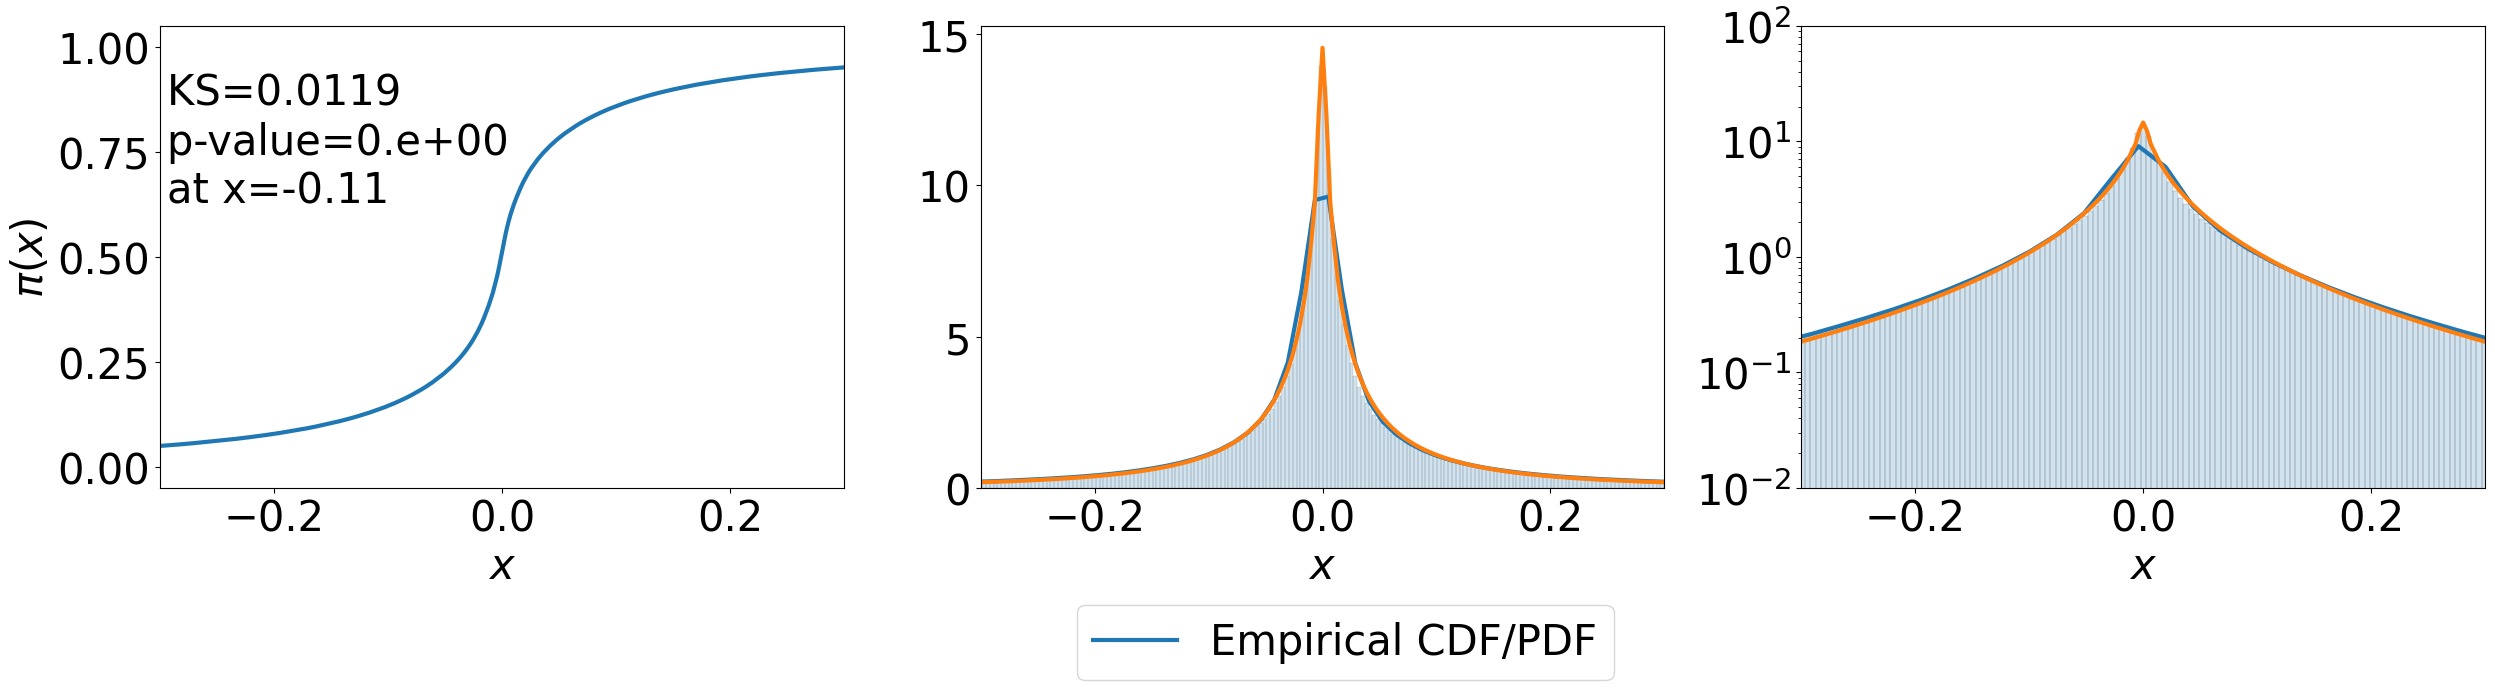

In [ ]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = 'green'

r1, eta1, scale1 = 0.08, 0.4, 3.272e-20
n_samples = 5000
group = 9


path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))
sample = group_data_map[group]
sample_size = group_total_samples[group]

params1 = (r1, eta1, scale1)
log_scale = True


distro='gengamma'
log_scale=True
n_samples=5000
interval=None
provided_loc=None
group=None
percent_excluded=0.1
plot_hist=True
bw=0.05
bw_log=0.05
binwidth=None
sample = sample 
fontsize=30
linewidth=3

def compute_cdf_pdf(params):
    if distro == 'gengamma':
        if len(params) == 3:
            r, eta, scale = params
        else:
            r, eta = params
            scale = 1
        xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale=scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
        null_pdf = null_cdf.derivative()(xs_pdf)
    elif distro == 'gaussian' or distro == 'normal':
        null_cdf = stats.norm(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.norm(scale=params).pdf(xs_pdf)
    elif distro == 'laplace':
        null_cdf = stats.laplace(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.laplace(scale=params).pdf(xs_pdf)
    return xs_pdf, null_cdf, null_pdf

xs_pdf1, null_cdf1, null_pdf1 = compute_cdf_pdf(params1)
if len(sample) > 0:
    lower_bound = np.percentile(sample, percent_excluded / 2)
    upper_bound = np.percentile(sample, 100 - percent_excluded / 2)
    original_sample = sample
    sample = sample[(sample > lower_bound) & (sample < upper_bound)]
    sample = np.sort(sample)
    n = len(sample)
    if interval is None:
        interval = (np.percentile(sample, 0.5), np.percentile(sample, 99.5))
    xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 20000000)
    print(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]))

if log_scale:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))

    if interval:
        ax1.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        ax1.plot(sample, np.arange(1, n + 1) / n, label='Empirical CDF/PDF', linewidth=linewidth)
        result1 = stats.ks_1samp(original_sample, null_cdf1)
        distance1, location1 = result1.statistic, np.round(result1.statistic_location, 2)

        pvalue = stats.kstwo.sf(distance1, sample_size)
        paramtext1 = rf"$r={params1[0]}, \eta={params1[1]}, \vartheta={np.format_float_scientific(params1[2], precision=2)}$"

        location1 = round(float(location1), 2)
        ax1.text(
            0.01, 0.9, 
            f"KS={np.round(distance1, 4)} \np-value={np.format_float_scientific(pvalue, precision=2)}\nat x={location1} ", 
            transform=ax1.transAxes, 
            fontsize=fontsize, 
            verticalalignment='top', 
            horizontalalignment='left'
        )
       
        
       
       

    if interval:
        ax2.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method=bw, ax=ax2, label=f'Empirical PDF (KDE, bw={bw})', linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax2, binwidth=binwidth, stat='density', label=f'Empirical PDF ({100 - percent_excluded}% of sample)', alpha=0.2)
    ax2.plot(xs_pdf1, null_pdf1, label='Computed PDF (params1)', linewidth=linewidth)


    if interval:
        ax3.set_xlim(left=interval[0], right=interval[1])
    ax3.set_ylim(bottom=10**-2, top=100)

    if len(sample) > 0:
        sns.kdeplot(ax=ax3, x=sample, bw_method=bw_log, log_scale=[False, True], label=f"Empirical PDF (KDE, bw={bw_log})", linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax3, binwidth=binwidth, stat="density", log=True, bins=1000, alpha=0.2, color='#1f77b4', label=f'Empirical PDF ({100 - percent_excluded}% of sample)')

    ax3.plot(xs_pdf1, null_pdf1, label="Computed PDF (params1)", linewidth=linewidth)

    # Move legend outside the plot and make it common for all subplots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, -0.05), ncol=4, fontsize=fontsize, markerscale=50)

    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=fontsize)
    ax3.tick_params(axis='both', which='major', labelsize=fontsize)

    ax1.set_ylabel(r"$\pi(x)$", fontsize=fontsize)
    ax2.set_ylabel("")
    ax3.set_ylabel("")

    ax1.set_xlabel(r"$x$", fontsize=fontsize)
    ax2.set_xlabel(r"$x$", fontsize=fontsize)
    ax3.set_xlabel(r"$x$", fontsize=fontsize)

    ax1.set_xlim((-0.3, 0.3))
    ax2.set_xlim((-0.3, 0.3))
    ax3.set_xlim((-0.3, 0.3))

    #plt.tight_layout()

    if SAVE_FIGS:
        save_path = os.path.join(plots_path, "borderline.jpg")
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')

    plt.show()




float

# Interesting Failure

Name the notebook:
learned_full_spaceNet.ipynb
-34.506634522348236 34.21932361308518
-0.6


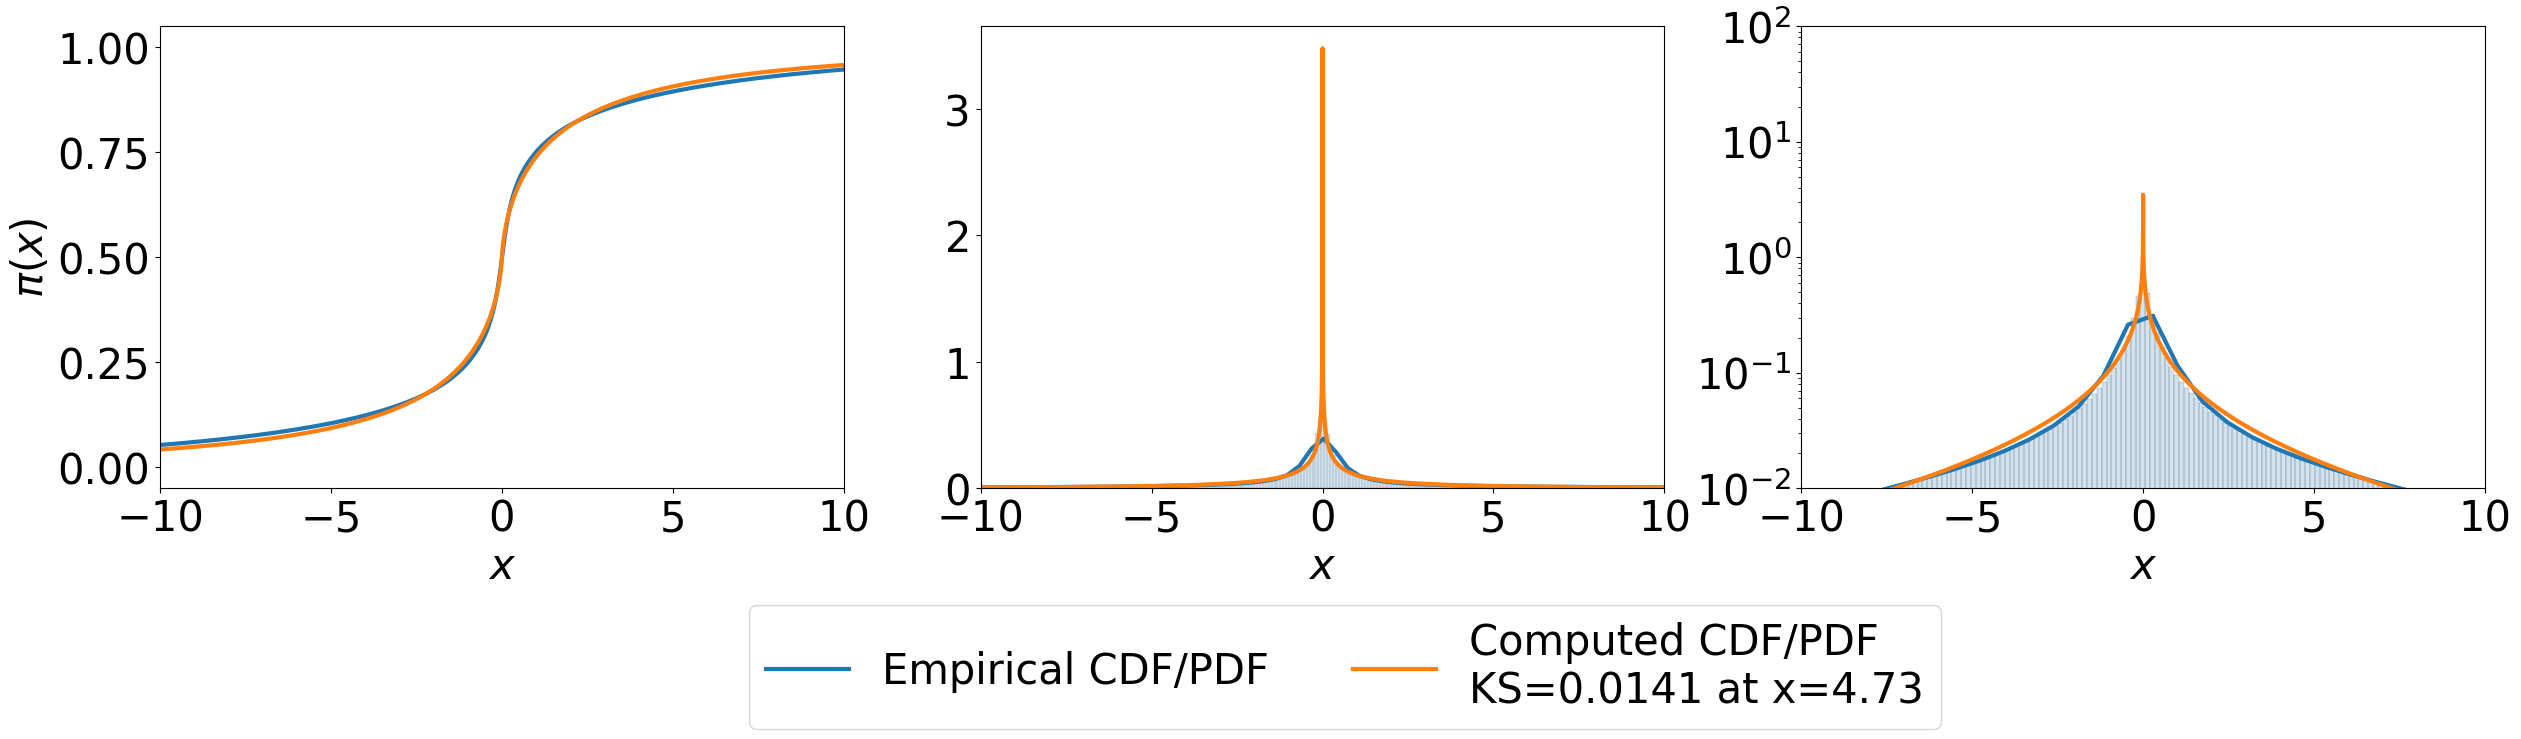

In [84]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'learned'
CHANNEL = ''

r1, eta1, scale1 = 0.3, -1.07, 2.927
n_samples = 5000
group = 49


path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))
sample = group_data_map[group]

params1 = (r1, eta1, scale1)
log_scale = True


distro='gengamma'
log_scale=True
n_samples=5000
interval=None
provided_loc=None
group=None
percent_excluded=0.1
plot_hist=True
bw=0.05
bw_log=0.05
binwidth=None
sample = sample 
fontsize=30
linewidth=3

def compute_cdf_pdf(params):
    if distro == 'gengamma':
        if len(params) == 3:
            r, eta, scale = params
        else:
            r, eta = params
            scale = 1
        xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale=scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
        null_pdf = null_cdf.derivative()(xs_pdf)
    elif distro == 'gaussian' or distro == 'normal':
        null_cdf = stats.norm(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.norm(scale=params).pdf(xs_pdf)
    elif distro == 'laplace':
        null_cdf = stats.laplace(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.laplace(scale=params).pdf(xs_pdf)
    return xs_pdf, null_cdf, null_pdf

xs_pdf1, null_cdf1, null_pdf1 = compute_cdf_pdf(params1)
if len(sample) > 0:
    lower_bound = np.percentile(sample, percent_excluded / 2)
    upper_bound = np.percentile(sample, 100 - percent_excluded / 2)
    original_sample = sample
    sample = sample[(sample > lower_bound) & (sample < upper_bound)]
    sample = np.sort(sample)
    n = len(sample)
    if interval is None:
        interval = (np.percentile(sample, 0.5), np.percentile(sample, 99.5))
    xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 20000000)
    print(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]))

if log_scale:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))

    if interval:
        ax1.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        ax1.plot(sample, np.arange(1, n + 1) / n, label='Empirical CDF/PDF', linewidth=linewidth)
        result1 = stats.ks_1samp(original_sample, null_cdf1)
        distance1, location1 = result1.statistic, np.round(result1.statistic_location, 2)

        paramtext1 = rf"$r={params1[0]}, \eta={params1[1]}, \vartheta={np.format_float_scientific(params1[2], precision=2)}$"
        
        paramtext1 = f"Computed CDF/PDF \nKS={np.round(distance1, 4)} at x={4.73}"
        
        print(location1)
        ax1.plot(xs, null_cdf1(xs), label=paramtext1, linewidth=linewidth)

    if interval:
        ax2.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method=bw, ax=ax2, label=f'Empirical PDF (KDE, bw={bw})', linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax2, binwidth=binwidth, stat='density', label=f'Empirical PDF ({100 - percent_excluded}% of sample)', alpha=0.2)
    ax2.plot(xs_pdf1, null_pdf1, label='Computed PDF (params1)', linewidth=linewidth)


    if interval:
        ax3.set_xlim(left=interval[0], right=interval[1])
    ax3.set_ylim(bottom=10**-2, top=100)

    if len(sample) > 0:
        sns.kdeplot(ax=ax3, x=sample, bw_method=bw_log, log_scale=[False, True], label=f"Empirical PDF (KDE, bw={bw_log})", linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax3, binwidth=binwidth, stat="density", log=True, bins=1000, alpha=0.2, color='#1f77b4', label=f'Empirical PDF ({100 - percent_excluded}% of sample)')

    ax3.plot(xs_pdf1, null_pdf1, label="Computed PDF (params1)", linewidth=linewidth)

    # Move legend outside the plot and make it common for all subplots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, -0.05), ncol=4, fontsize=fontsize, markerscale=50)

    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=fontsize)
    ax3.tick_params(axis='both', which='major', labelsize=fontsize)

    ax1.set_ylabel(r"$\pi(x)$", fontsize=fontsize)
    ax2.set_ylabel("")
    ax3.set_ylabel("")

    ax1.set_xlabel(r"$x$", fontsize=fontsize)
    ax2.set_xlabel(r"$x$", fontsize=fontsize)
    ax3.set_xlabel(r"$x$", fontsize=fontsize)

    ax1.set_xlim((-10, 10))
    ax2.set_xlim((-10, 10))
    ax3.set_xlim((-10, 10))

    #plt.tight_layout()

    if SAVE_FIGS:
        save_path = os.path.join(plots_path, "interesting_failure.jpg")
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')

    plt.show()




# Trivial Failure

## Asymmetric

Name the notebook:
gray_horizontal_wavelet_outdoor_coco.ipynb
-102.7877 111.73024
1.84


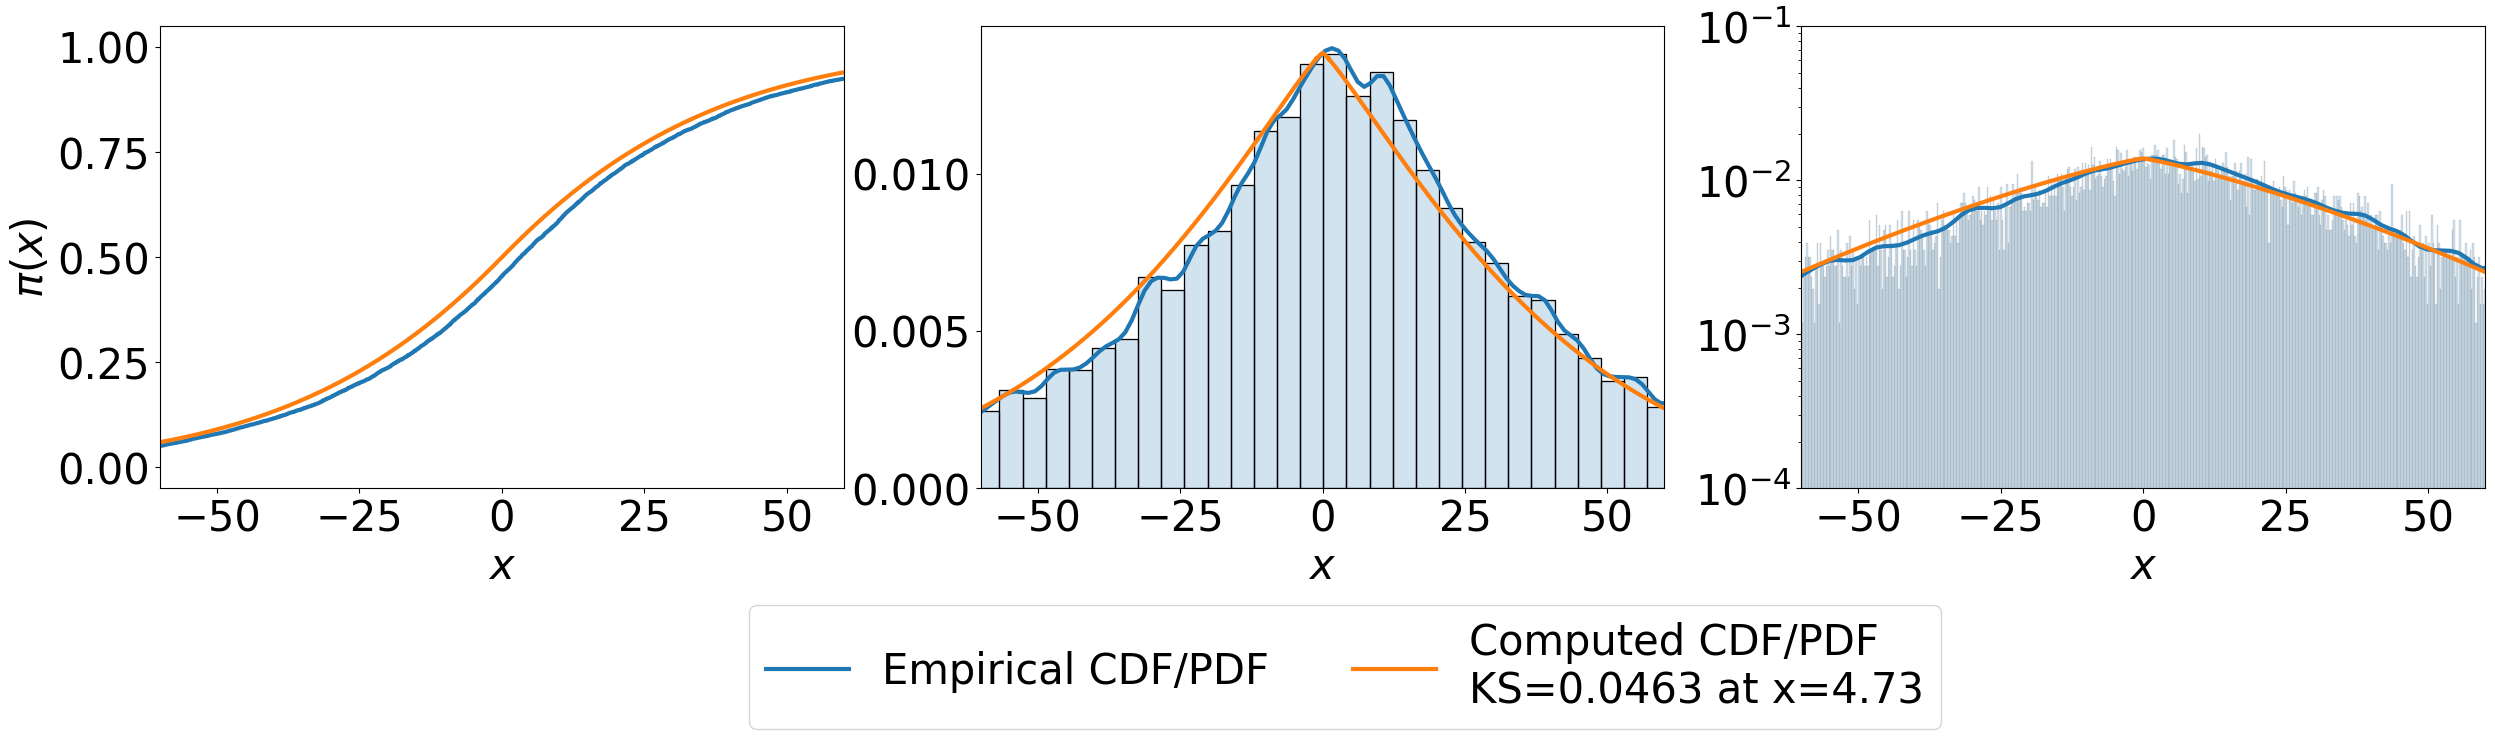

In [ ]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'gray'

r1, eta1, scale1 = 8.3, -0.4, 2.938e3
n_samples = 5000
group = 3


path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))
sample = group_data_map[group]

params1 = (r1, eta1, scale1)
log_scale = True


distro='gengamma'
log_scale=True
n_samples=5000
interval=None
provided_loc=None
group=None
percent_excluded=0.1
plot_hist=True
bw=0.05
bw_log=0.05
binwidth=None
sample = sample 
fontsize=30
linewidth=3

def compute_cdf_pdf(params):
    if distro == 'gengamma':
        if len(params) == 3:
            r, eta, scale = params
        else:
            r, eta = params
            scale = 1
        xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale=scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
        null_pdf = null_cdf.derivative()(xs_pdf)
    elif distro == 'gaussian' or distro == 'normal':
        null_cdf = stats.norm(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.norm(scale=params).pdf(xs_pdf)
    elif distro == 'laplace':
        null_cdf = stats.laplace(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.laplace(scale=params).pdf(xs_pdf)
    return xs_pdf, null_cdf, null_pdf

xs_pdf1, null_cdf1, null_pdf1 = compute_cdf_pdf(params1)
if len(sample) > 0:
    lower_bound = np.percentile(sample, percent_excluded / 2)
    upper_bound = np.percentile(sample, 100 - percent_excluded / 2)
    original_sample = sample
    sample = sample[(sample > lower_bound) & (sample < upper_bound)]
    sample = np.sort(sample)
    n = len(sample)
    if interval is None:
        interval = (np.percentile(sample, 0.5), np.percentile(sample, 99.5))
    xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 20000000)
    print(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]))

if log_scale:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))

    if interval:
        ax1.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        ax1.plot(sample, np.arange(1, n + 1) / n, label='Empirical CDF/PDF', linewidth=linewidth)
        result1 = stats.ks_1samp(original_sample, null_cdf1)
        distance1, location1 = result1.statistic, np.round(result1.statistic_location, 2)

        paramtext1 = rf"$r={params1[0]}, \eta={params1[1]}, \vartheta={np.format_float_scientific(params1[2], precision=2)}$"
        
        paramtext1 = f"Computed CDF/PDF \nKS={np.round(distance1, 4)} at x={4.73}"
        
        print(location1)
        ax1.plot(xs, null_cdf1(xs), label=paramtext1, linewidth=linewidth)

    if interval:
        ax2.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method=bw, ax=ax2, label=f'Empirical PDF (KDE, bw={bw})', linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax2, binwidth=binwidth, stat='density', label=f'Empirical PDF ({100 - percent_excluded}% of sample)', alpha=0.2)
    ax2.plot(xs_pdf1, null_pdf1, label='Computed PDF (params1)', linewidth=linewidth)


    if interval:
        ax3.set_xlim(left=interval[0], right=interval[1])
    ax3.set_ylim(bottom=10**-4, top=0.1)

    if len(sample) > 0:
        sns.kdeplot(ax=ax3, x=sample, bw_method=bw_log, log_scale=[False, True], label=f"Empirical PDF (KDE, bw={bw_log})", linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax3, binwidth=binwidth, stat="density", log=True, bins=1000, alpha=0.2, color='#1f77b4', label=f'Empirical PDF ({100 - percent_excluded}% of sample)')

    ax3.plot(xs_pdf1, null_pdf1, label="Computed PDF (params1)", linewidth=linewidth)

    # Move legend outside the plot and make it common for all subplots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, -0.05), ncol=4, fontsize=fontsize, markerscale=50)

    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=fontsize)
    ax3.tick_params(axis='both', which='major', labelsize=fontsize)

    ax1.set_ylabel(r"$\pi(x)$", fontsize=fontsize)
    ax2.set_ylabel("")
    ax3.set_ylabel("")

    ax1.set_xlabel(r"$x$", fontsize=fontsize)
    ax2.set_xlabel(r"$x$", fontsize=fontsize)
    ax3.set_xlabel(r"$x$", fontsize=fontsize)

    ax1.set_xlim((-60, 60))
    ax2.set_xlim((-60, 60))
    ax3.set_xlim((-60, 60))

    #plt.tight_layout()

    if SAVE_FIGS:
        save_path = os.path.join(plots_path, "trivial_failure_asymmetric.jpg")
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')

    plt.show()




## Multimodal

Name the notebook:
horizontal_wavelet_axial_syntheticMRI2D.ipynb
-1917.0988 1916.831
178.09


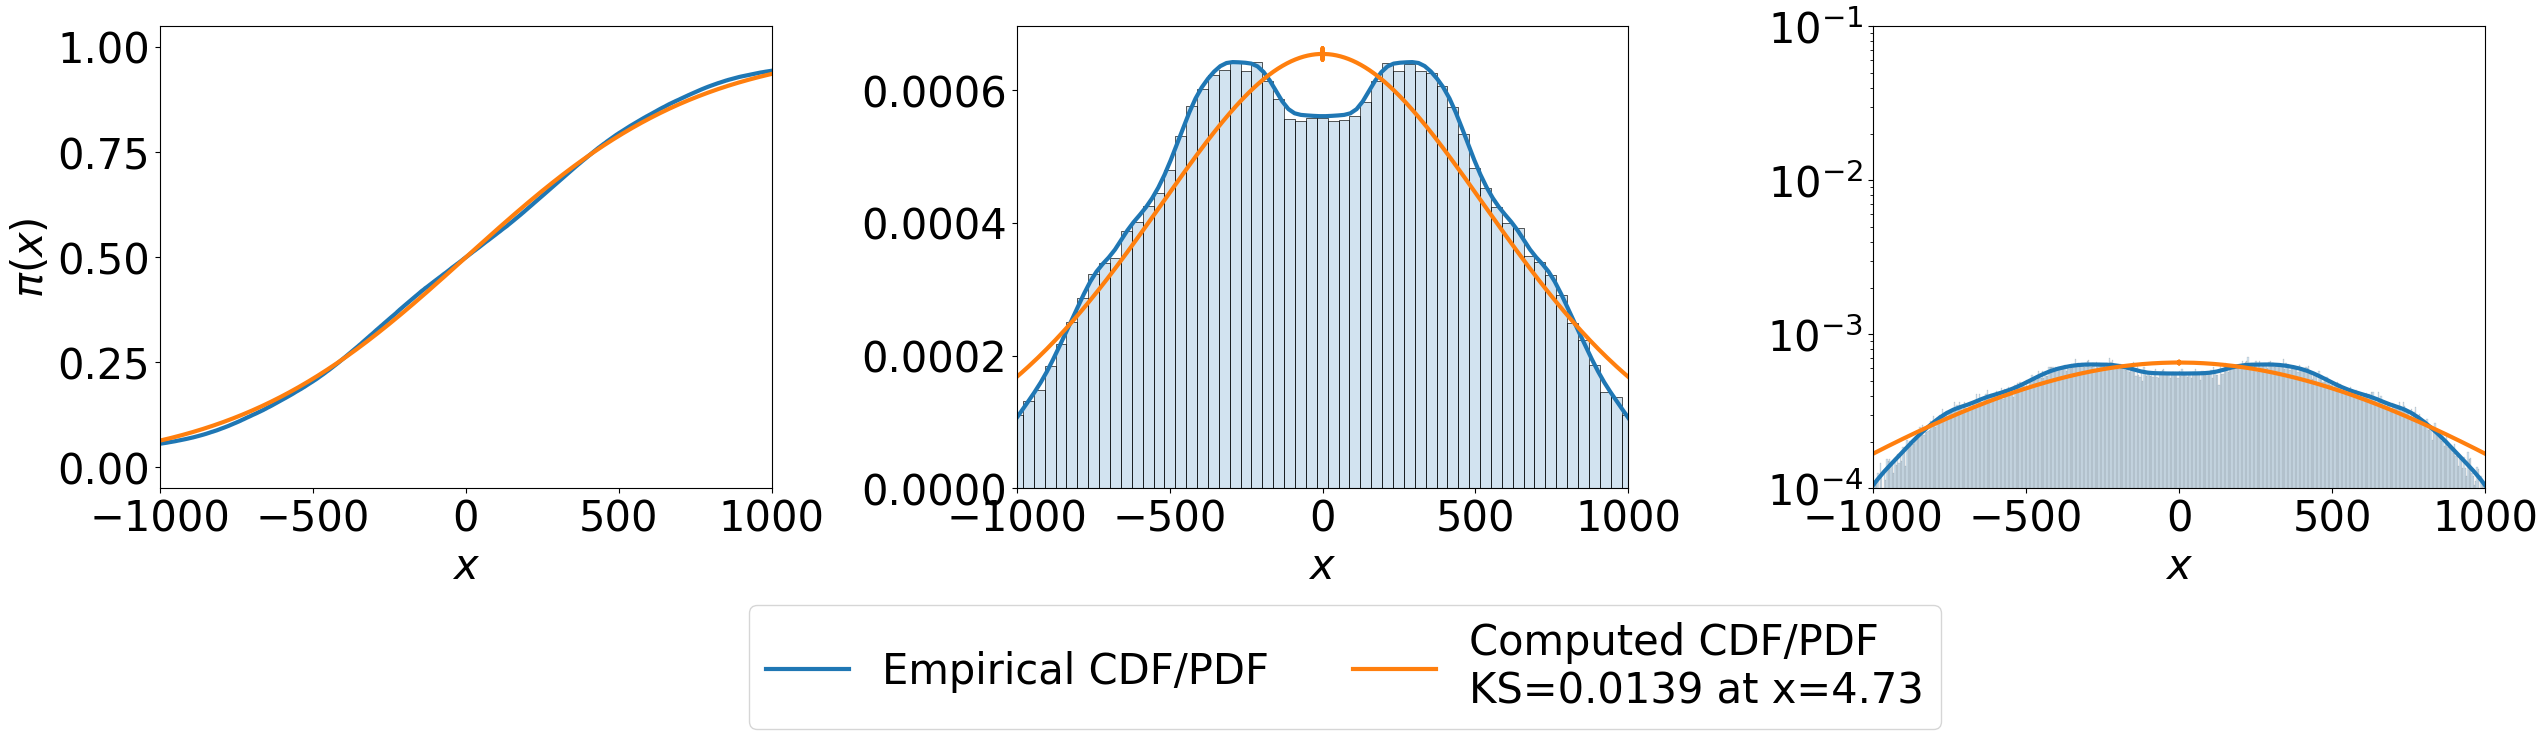

In [86]:
DATA_NAME = 'syntheticMRI2D-axial' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = ''

r1, eta1, scale1 = 0.2, 19, 3.574e-5
group = 4


path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))
sample = group_data_map[group]

params1 = (r1, eta1, scale1)
log_scale = True


distro='gengamma'
log_scale=True
n_samples=5000
interval=None
provided_loc=None
group=None
percent_excluded=0.1
plot_hist=True
bw=0.05
bw_log=0.05
binwidth=None
sample = sample 
fontsize=30
linewidth=3

def compute_cdf_pdf(params):
    if distro == 'gengamma':
        if len(params) == 3:
            r, eta, scale = params
        else:
            r, eta = params
            scale = 1
        xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale=scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
        null_pdf = null_cdf.derivative()(xs_pdf)
    elif distro == 'gaussian' or distro == 'normal':
        null_cdf = stats.norm(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.norm(scale=params).pdf(xs_pdf)
    elif distro == 'laplace':
        null_cdf = stats.laplace(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.laplace(scale=params).pdf(xs_pdf)
    return xs_pdf, null_cdf, null_pdf

xs_pdf1, null_cdf1, null_pdf1 = compute_cdf_pdf(params1)
if len(sample) > 0:
    lower_bound = np.percentile(sample, percent_excluded / 2)
    upper_bound = np.percentile(sample, 100 - percent_excluded / 2)
    original_sample = sample
    sample = sample[(sample > lower_bound) & (sample < upper_bound)]
    sample = np.sort(sample)
    n = len(sample)
    if interval is None:
        interval = (np.percentile(sample, 0.5), np.percentile(sample, 99.5))
    xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 20000000)
    print(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]))

if log_scale:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))

    if interval:
        ax1.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        ax1.plot(sample, np.arange(1, n + 1) / n, label='Empirical CDF/PDF', linewidth=linewidth)
        result1 = stats.ks_1samp(original_sample, null_cdf1)
        distance1, location1 = result1.statistic, np.round(result1.statistic_location, 2)

        paramtext1 = rf"$r={params1[0]}, \eta={params1[1]}, \vartheta={np.format_float_scientific(params1[2], precision=2)}$"
        
        paramtext1 = f"Computed CDF/PDF \nKS={np.round(distance1, 4)} at x={4.73}"
        
        print(location1)
        ax1.plot(xs, null_cdf1(xs), label=paramtext1, linewidth=linewidth)

    if interval:
        ax2.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method=bw, ax=ax2, label=f'Empirical PDF (KDE, bw={bw})', linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax2, binwidth=binwidth, stat='density', label=f'Empirical PDF ({100 - percent_excluded}% of sample)', alpha=0.2)
    ax2.plot(xs_pdf1, null_pdf1, label='Computed PDF (params1)', linewidth=linewidth)


    if interval:
        ax3.set_xlim(left=interval[0], right=interval[1])
    ax3.set_ylim(bottom=10**-4, top=0.1)

    if len(sample) > 0:
        sns.kdeplot(ax=ax3, x=sample, bw_method=bw_log, log_scale=[False, True], label=f"Empirical PDF (KDE, bw={bw_log})", linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax3, binwidth=binwidth, stat="density", log=True, bins=1000, alpha=0.2, color='#1f77b4', label=f'Empirical PDF ({100 - percent_excluded}% of sample)')

    ax3.plot(xs_pdf1, null_pdf1, label="Computed PDF (params1)", linewidth=linewidth)

    # Move legend outside the plot and make it common for all subplots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, -0.05), ncol=4, fontsize=fontsize, markerscale=50)

    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=fontsize)
    ax3.tick_params(axis='both', which='major', labelsize=fontsize)

    ax1.set_ylabel(r"$\pi(x)$", fontsize=fontsize)
    ax2.set_ylabel("")
    #ax2.set_ylabel("", labelpad=40)
    ax3.set_ylabel("")

    ax1.set_xlabel(r"$x$", fontsize=fontsize)
    ax2.set_xlabel(r"$x$", fontsize=fontsize)
    ax3.set_xlabel(r"$x$", fontsize=fontsize)

    ax1.set_xlim((-1000, 1000))
    ax2.set_xlim((-1000, 1000))
    ax3.set_xlim((-1000, 1000))

    plt.subplots_adjust(wspace=0.4)
    #plt.tight_layout()

    if SAVE_FIGS:
        save_path = os.path.join(plots_path, "trivial_failure_multimodal.jpg")
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')

    plt.show()




## Double Inflection Point

Name the notebook:
dad_wavelet_full_syntheticMRI3D.ipynb
-2051.5671 2051.569
-163.33


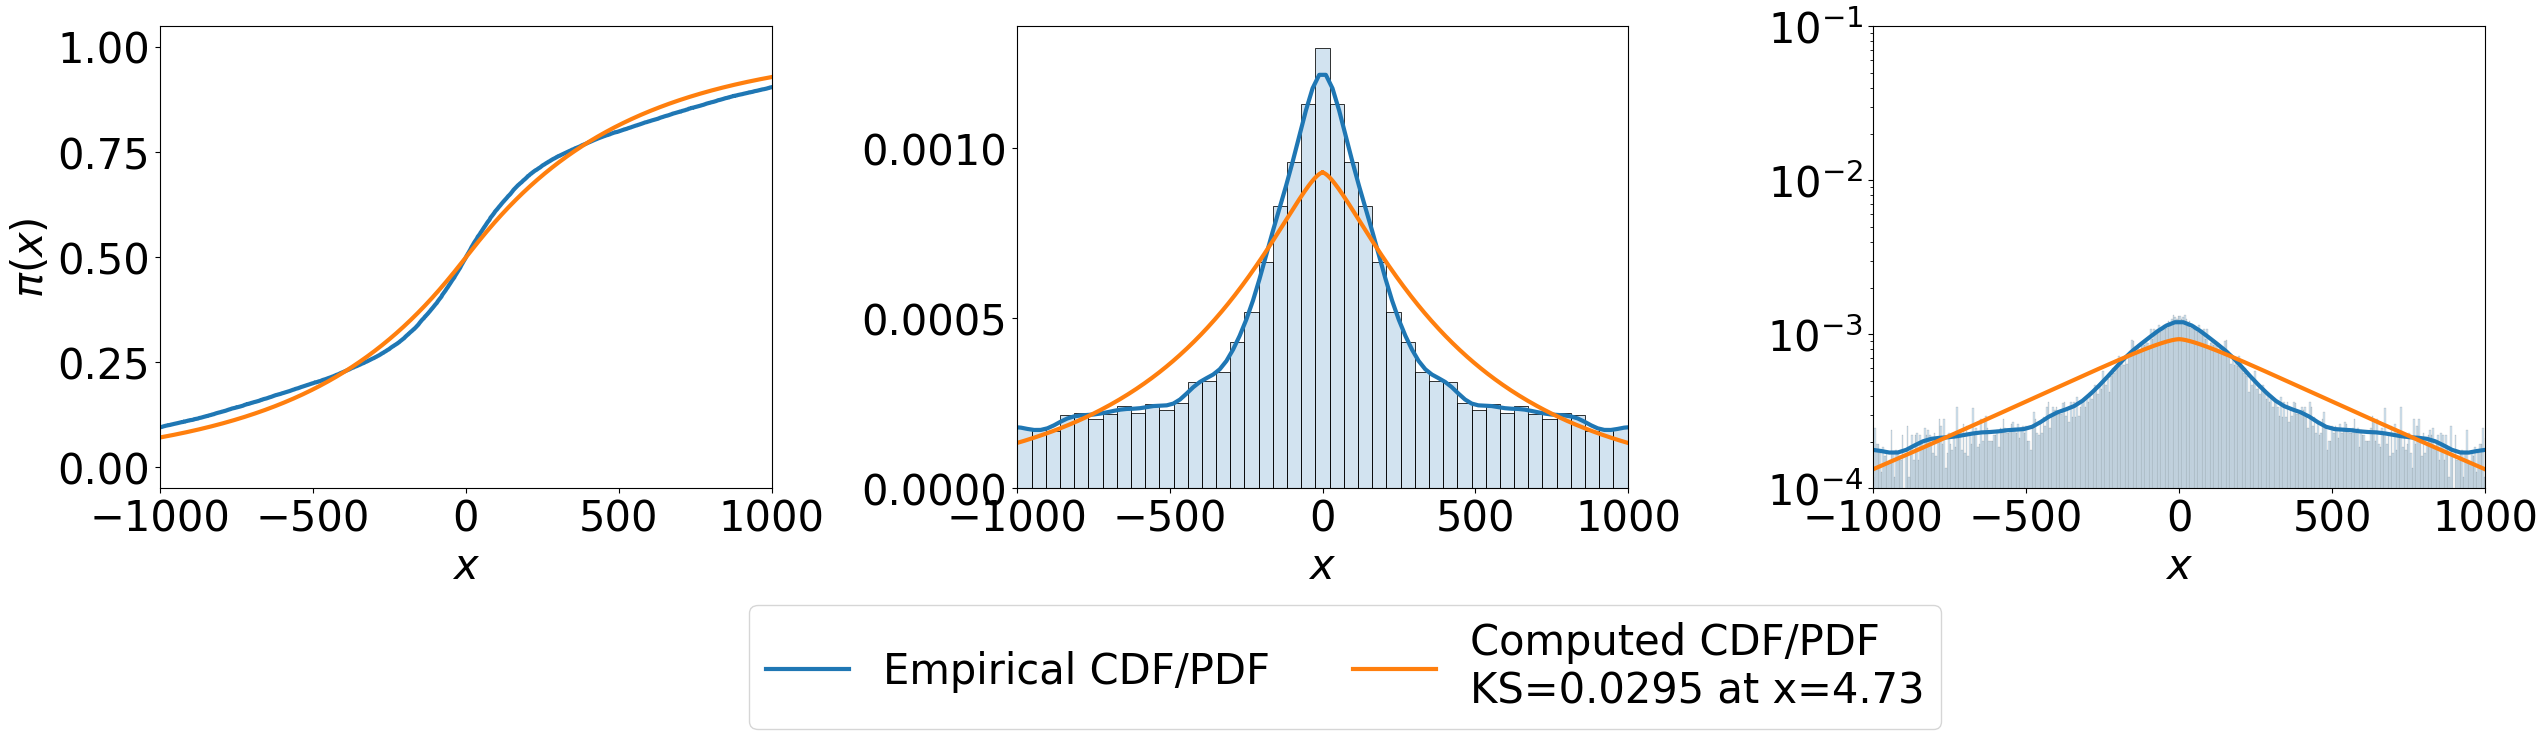

In [87]:
DATA_NAME = 'syntheticMRI3D-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'dad'

r1, eta1, scale1 = 0.55, -0.1, 7.892e4
group = 4


path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))
sample = group_data_map[group]

params1 = (r1, eta1, scale1)
log_scale = True


distro='gengamma'
log_scale=True
n_samples=5000
interval=None
provided_loc=None
group=None
percent_excluded=0.1
plot_hist=True
bw=0.05
bw_log=0.05
binwidth=None
sample = sample 
fontsize=30
linewidth=3

def compute_cdf_pdf(params):
    if distro == 'gengamma':
        if len(params) == 3:
            r, eta, scale = params
        else:
            r, eta = params
            scale = 1
        xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale=scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
        null_pdf = null_cdf.derivative()(xs_pdf)
    elif distro == 'gaussian' or distro == 'normal':
        null_cdf = stats.norm(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.norm(scale=params).pdf(xs_pdf)
    elif distro == 'laplace':
        null_cdf = stats.laplace(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.laplace(scale=params).pdf(xs_pdf)
    return xs_pdf, null_cdf, null_pdf

xs_pdf1, null_cdf1, null_pdf1 = compute_cdf_pdf(params1)
if len(sample) > 0:
    lower_bound = np.percentile(sample, percent_excluded / 2)
    upper_bound = np.percentile(sample, 100 - percent_excluded / 2)
    original_sample = sample
    sample = sample[(sample > lower_bound) & (sample < upper_bound)]
    sample = np.sort(sample)
    n = len(sample)
    if interval is None:
        interval = (np.percentile(sample, 0.5), np.percentile(sample, 99.5))
    xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 20000000)
    print(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]))

if log_scale:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))

    if interval:
        ax1.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        ax1.plot(sample, np.arange(1, n + 1) / n, label='Empirical CDF/PDF', linewidth=linewidth)
        result1 = stats.ks_1samp(original_sample, null_cdf1)
        distance1, location1 = result1.statistic, np.round(result1.statistic_location, 2)

        paramtext1 = rf"$r={params1[0]}, \eta={params1[1]}, \vartheta={np.format_float_scientific(params1[2], precision=2)}$"
        
        paramtext1 = f"Computed CDF/PDF \nKS={np.round(distance1, 4)} at x={4.73}"
        
        print(location1)
        ax1.plot(xs, null_cdf1(xs), label=paramtext1, linewidth=linewidth)

    if interval:
        ax2.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method=bw, ax=ax2, label=f'Empirical PDF (KDE, bw={bw})', linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax2, binwidth=binwidth, stat='density', label=f'Empirical PDF ({100 - percent_excluded}% of sample)', alpha=0.2)
    ax2.plot(xs_pdf1, null_pdf1, label='Computed PDF (params1)', linewidth=linewidth)


    if interval:
        ax3.set_xlim(left=interval[0], right=interval[1])
    ax3.set_ylim(bottom=10**-4, top=0.1)

    if len(sample) > 0:
        sns.kdeplot(ax=ax3, x=sample, bw_method=bw_log, log_scale=[False, True], label=f"Empirical PDF (KDE, bw={bw_log})", linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax3, binwidth=binwidth, stat="density", log=True, bins=1000, alpha=0.2, color='#1f77b4', label=f'Empirical PDF ({100 - percent_excluded}% of sample)')

    ax3.plot(xs_pdf1, null_pdf1, label="Computed PDF (params1)", linewidth=linewidth)

    # Move legend outside the plot and make it common for all subplots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, -0.05), ncol=4, fontsize=fontsize, markerscale=50)

    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=fontsize)
    ax3.tick_params(axis='both', which='major', labelsize=fontsize)

    ax1.set_ylabel(r"$\pi(x)$", fontsize=fontsize)
    ax2.set_ylabel("")
    ax3.set_ylabel("")

    ax1.set_xlabel(r"$x$", fontsize=fontsize)
    ax2.set_xlabel(r"$x$", fontsize=fontsize)
    ax3.set_xlabel(r"$x$", fontsize=fontsize)

    ax1.set_xlim((-1000, 1000))
    ax2.set_xlim((-1000, 1000))
    ax3.set_xlim((-1000, 1000))

    plt.subplots_adjust(wspace=0.4)
    #plt.tight_layout()

    if SAVE_FIGS:
        save_path = os.path.join(plots_path, "trivial_failure_double_inflection.jpg")
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')

    plt.show()




## Spike and Slab

Name the notebook:
blue_diagonal_wavelet_full_spaceNet.ipynb
-134.47687 133.53383
0.0


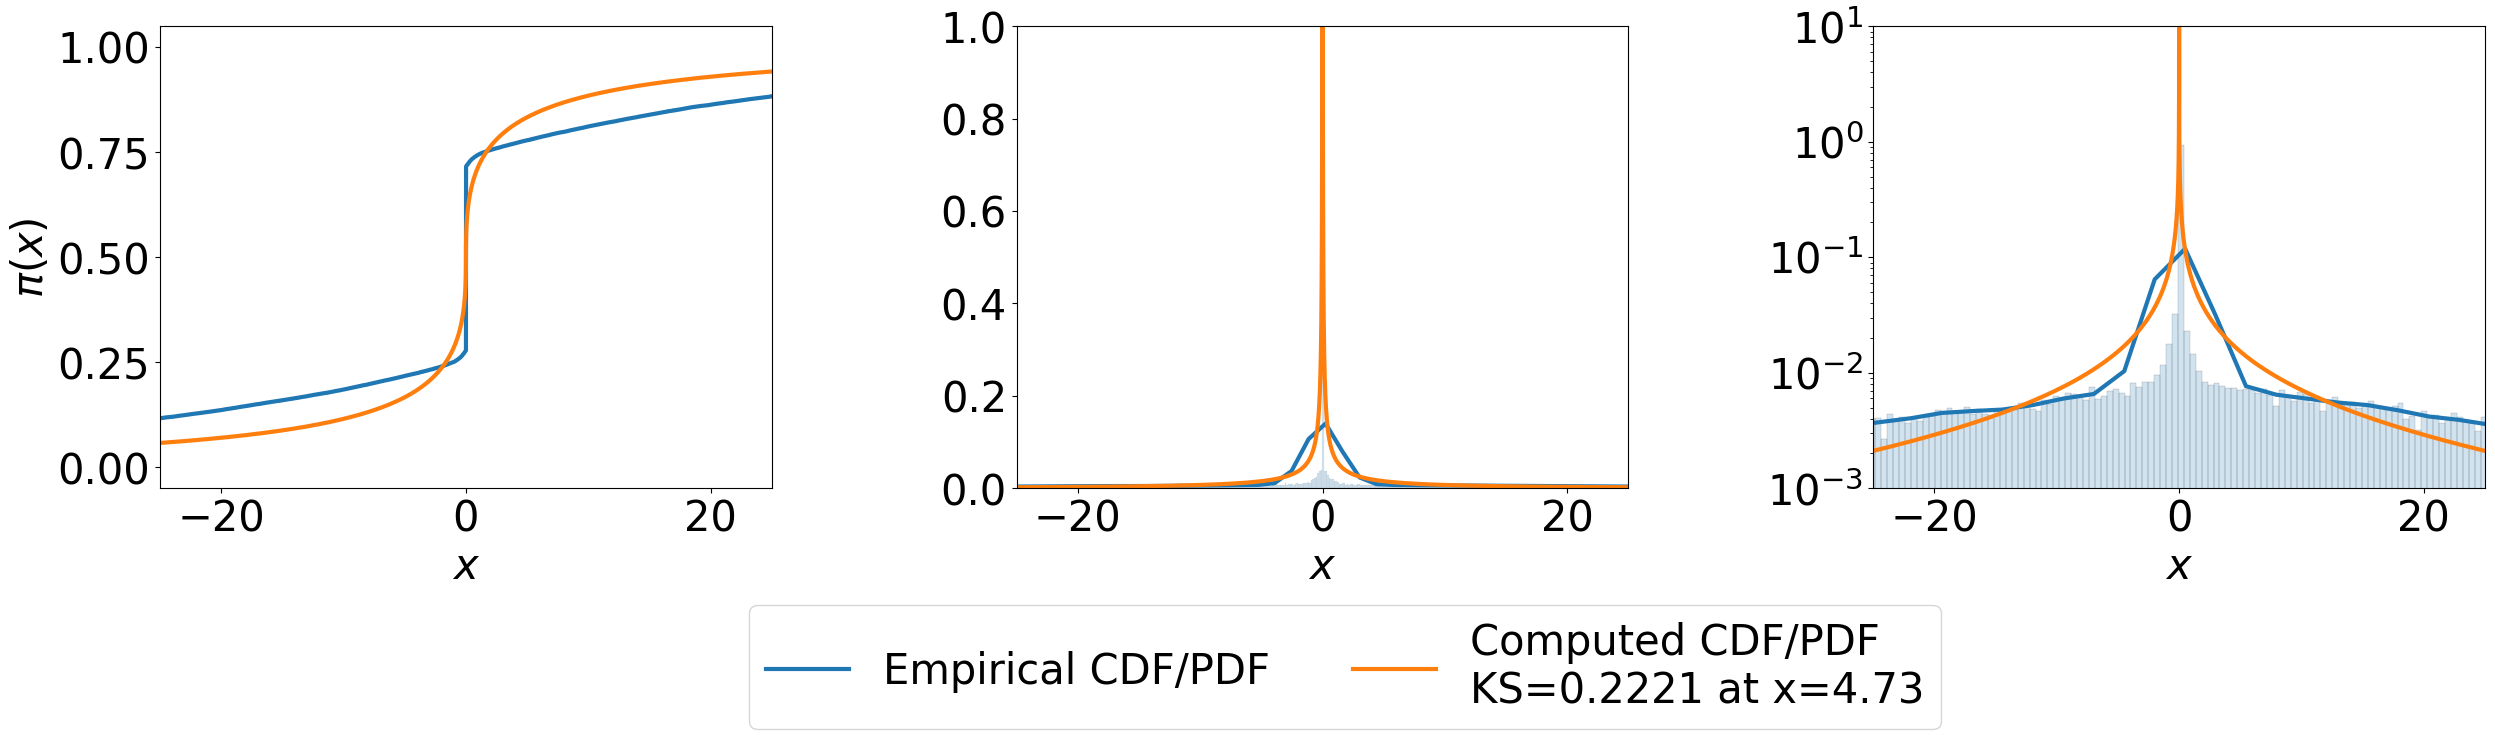

In [88]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'blue'

r1, eta1, scale1 = 0.3, -1.3, 2.706e2
group = 3


path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))
sample = group_data_map[group]

params1 = (r1, eta1, scale1)
log_scale = True


distro='gengamma'
log_scale=True
n_samples=5000
interval=None
provided_loc=None
group=None
percent_excluded=0.1
plot_hist=True
bw=0.05
bw_log=0.05
binwidth=None
sample = sample 
fontsize=30
linewidth=3

def compute_cdf_pdf(params):
    if distro == 'gengamma':
        if len(params) == 3:
            r, eta, scale = params
        else:
            r, eta = params
            scale = 1
        xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale=scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
        null_pdf = null_cdf.derivative()(xs_pdf)
    elif distro == 'gaussian' or distro == 'normal':
        null_cdf = stats.norm(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.norm(scale=params).pdf(xs_pdf)
    elif distro == 'laplace':
        null_cdf = stats.laplace(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.laplace(scale=params).pdf(xs_pdf)
    return xs_pdf, null_cdf, null_pdf

xs_pdf1, null_cdf1, null_pdf1 = compute_cdf_pdf(params1)
if len(sample) > 0:
    lower_bound = np.percentile(sample, percent_excluded / 2)
    upper_bound = np.percentile(sample, 100 - percent_excluded / 2)
    original_sample = sample
    sample = sample[(sample > lower_bound) & (sample < upper_bound)]
    sample = np.sort(sample)
    n = len(sample)
    if interval is None:
        interval = (np.percentile(sample, 0.5), np.percentile(sample, 99.5))
    xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 20000000)
    print(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]))

if log_scale:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))

    if interval:
        ax1.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        ax1.plot(sample, np.arange(1, n + 1) / n, label='Empirical CDF/PDF', linewidth=linewidth)
        result1 = stats.ks_1samp(original_sample, null_cdf1)
        distance1, location1 = result1.statistic, np.round(result1.statistic_location, 2)

        paramtext1 = rf"$r={params1[0]}, \eta={params1[1]}, \vartheta={np.format_float_scientific(params1[2], precision=2)}$"
        
        paramtext1 = f"Computed CDF/PDF \nKS={np.round(distance1, 4)} at x={4.73}"
        
        print(location1)
        ax1.plot(xs, null_cdf1(xs), label=paramtext1, linewidth=linewidth)

    if interval:
        ax2.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method=bw, ax=ax2, label=f'Empirical PDF (KDE, bw={bw})', linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax2, binwidth=binwidth, stat='density', label=f'Empirical PDF ({100 - percent_excluded}% of sample)', alpha=0.2)
    ax2.plot(xs_pdf1, null_pdf1, label='Computed PDF (params1)', linewidth=linewidth)


    if interval:
        ax3.set_xlim(left=interval[0], right=interval[1])
    ax3.set_ylim(bottom=10**-3, top=10)

    ax2.set_ylim(bottom=0, top=1)

    if len(sample) > 0:
        sns.kdeplot(ax=ax3, x=sample, bw_method=bw_log, log_scale=[False, True], label=f"Empirical PDF (KDE, bw={bw_log})", linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax3, binwidth=binwidth, stat="density", log=True, bins=1000, alpha=0.2, color='#1f77b4', label=f'Empirical PDF ({100 - percent_excluded}% of sample)')

    ax3.plot(xs_pdf1, null_pdf1, label="Computed PDF (params1)", linewidth=linewidth)

    # Move legend outside the plot and make it common for all subplots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, -0.05), ncol=4, fontsize=fontsize, markerscale=50)

    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=fontsize)
    ax3.tick_params(axis='both', which='major', labelsize=fontsize)

    ax1.set_ylabel(r"$\pi(x)$", fontsize=fontsize)
    ax2.set_ylabel("")
    ax3.set_ylabel("")

    ax1.set_xlabel(r"$x$", fontsize=fontsize)
    ax2.set_xlabel(r"$x$", fontsize=fontsize)
    ax3.set_xlabel(r"$x$", fontsize=fontsize)

    ax1.set_xlim((-25, 25))
    ax2.set_xlim((-25, 25))
    ax3.set_xlim((-25, 25))

    plt.subplots_adjust(wspace=0.4)
    #plt.tight_layout()

    if SAVE_FIGS:
        save_path = os.path.join(plots_path, "trivial_failure_spike_and_slab.jpg")
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')

    plt.show()




# All together

Name the notebook:
green_diagonal_wavelet_full_agriVision.ipynb
-238.61386 255.76952
-5.21
Name the notebook:
blue_diagonal_wavelet_full_segmentAnything.ipynb
-93.80506 91.13846
0.73
Name the notebook:
green_vertical_wavelet_indoor_coco.ipynb
-102.58447 98.53124
1.03
Name the notebook:
learned_full_spaceNet.ipynb
-18.117731364294617 17.868305717961515
4.76


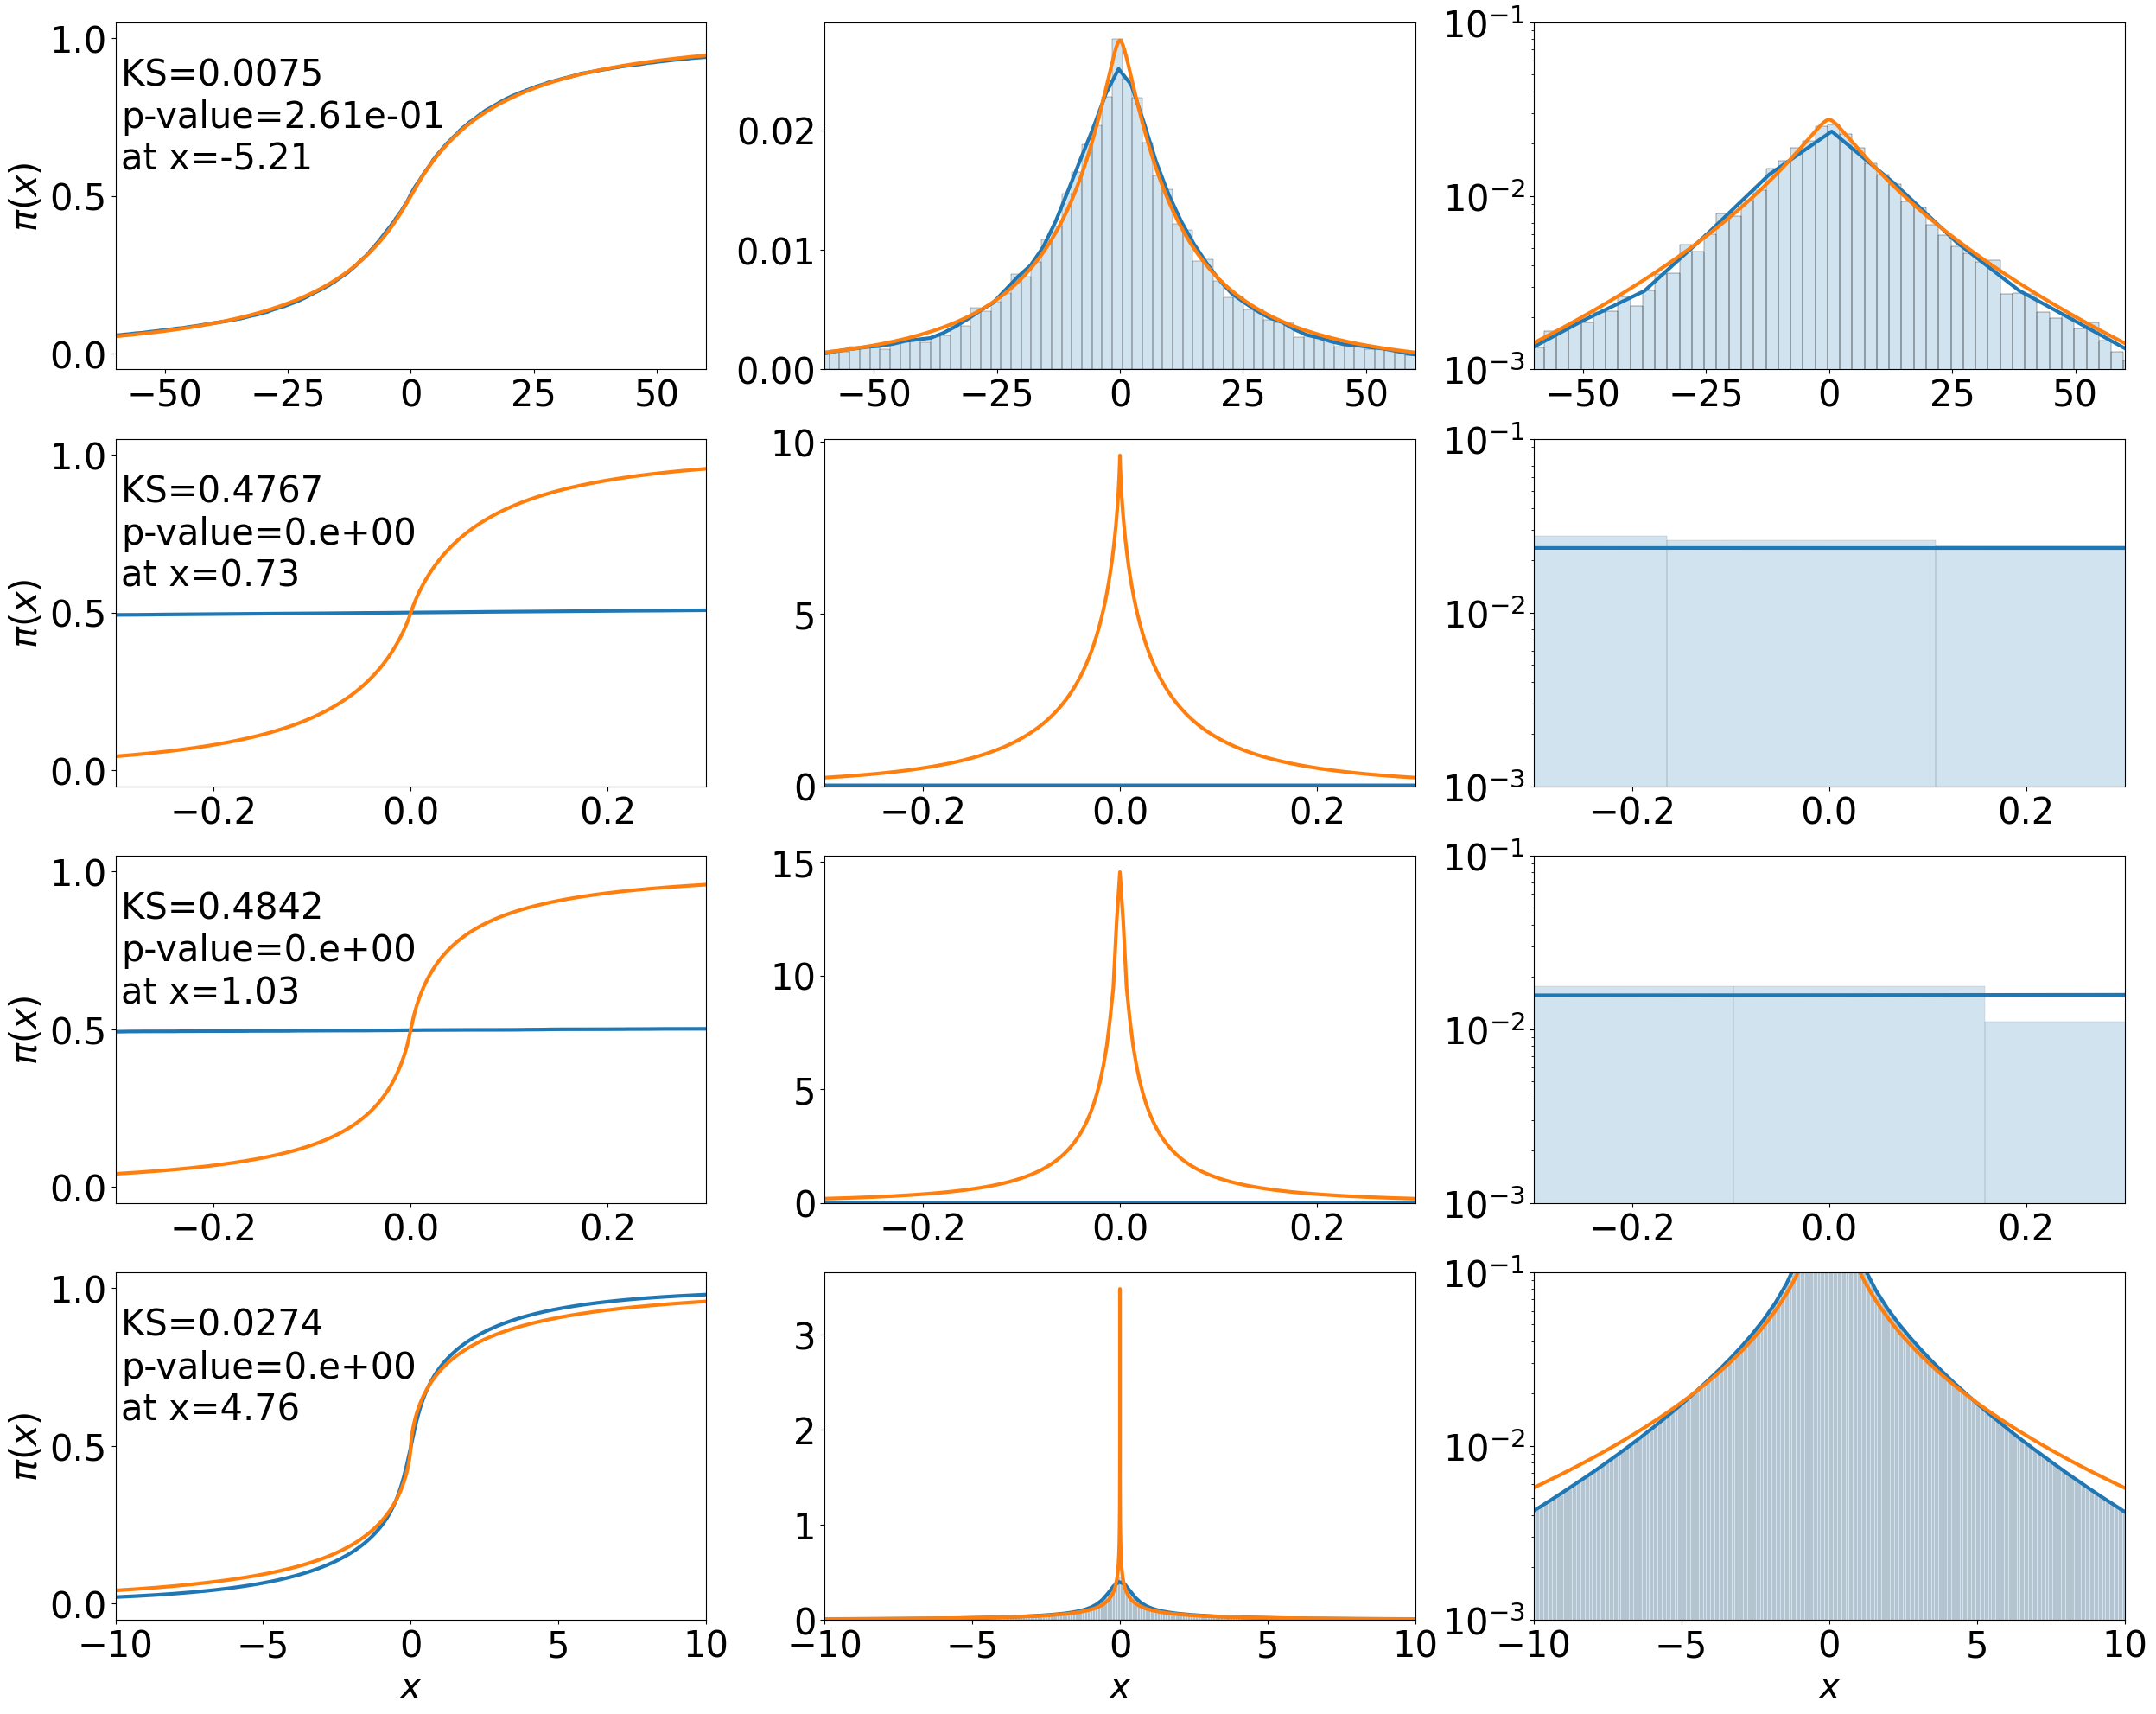

In [119]:
names = ["actually_pass", "practically_pass", "borderline", "interesting_failure"]
DATA_NAMES = ['agriVision-full','segmentAnything-full', 'coco-indoor', 'spaceNet-full'] 
TRANSFORMS = ['wavelet-diagonal','wavelet-diagonal', 'wavelet-vertical', 'learned']
CHANNELS = ['green', "blue", "green", '']

r1s, eta1s, scale1s = [0.09, 0.29, 0.08, 0.3], [1.9, -0.6, 0.4, -1.07], [1.743e-15, 2.792e-4, 3.272e-20, 2.927]
groups= [3, 10, 9, 49]
n_samples = 5000
xlims = [60, 0.3, 0.3, 10]



fig, axes = plt.subplots(4, 3, figsize=(30, 24))

for i in range(4):
    DATA_NAME = DATA_NAMES[i]
    TRANSFORM = TRANSFORMS[i]
    CHANNEL = CHANNELS[i]
    r1, eta1, scale1 = r1s[i], eta1s[i], scale1s[i]
    group = groups[i]
    ax1, ax2, ax3 = axes[i]
    xlim = xlims[i]

    path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
    if CHANNEL:
        path_list.append(CHANNEL)
    print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
    FULL_DATA_NAME='-'.join(path_list)

    group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
    group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))


    sample = group_data_map[3]
    sample_size = group_total_samples[3]

    params1 = (r1, eta1, scale1)
    log_scale = True


    distro='gengamma'
    log_scale=True
    n_samples=5000
    interval=None
    provided_loc=None
    group=None
    percent_excluded=0.1
    plot_hist=True
    bw=0.05
    bw_log=0.05
    binwidth=None
    sample = sample 
    fontsize=30
    linewidth=3

    def compute_cdf_pdf(params):
        if distro == 'gengamma':
            if len(params) == 3:
                r, eta, scale = params
            else:
                r, eta = params
                scale = 1
            xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale=scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
            null_pdf = null_cdf.derivative()(xs_pdf)
        elif distro == 'gaussian' or distro == 'normal':
            null_cdf = stats.norm(scale=params).cdf
            xs_pdf = np.linspace(-30, 30, 10000)
            null_pdf = stats.norm(scale=params).pdf(xs_pdf)
        elif distro == 'laplace':
            null_cdf = stats.laplace(scale=params).cdf
            xs_pdf = np.linspace(-30, 30, 10000)
            null_pdf = stats.laplace(scale=params).pdf(xs_pdf)
        return xs_pdf, null_cdf, null_pdf

    xs_pdf1, null_cdf1, null_pdf1 = compute_cdf_pdf(params1)


    if len(sample) > 0:
        lower_bound = np.percentile(sample, percent_excluded / 2)
        upper_bound = np.percentile(sample, 100 - percent_excluded / 2)
        original_sample = sample
        sample = sample[(sample > lower_bound) & (sample < upper_bound)]
        sample = np.sort(sample)
        n = len(sample)
        if interval is None:
            interval = (np.percentile(sample, 0.5), np.percentile(sample, 99.5))
        xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 20000000)
        print(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]))

    if log_scale:
        

        if interval:
            ax1.set_xlim(left=interval[0], right=interval[1])

        if len(sample) > 0:
            ax1.plot(sample, np.arange(1, n + 1) / n, label='Empirical CDF/PDF', linewidth=linewidth)
            result1 = stats.ks_1samp(original_sample, null_cdf1)
            distance1, location1 = result1.statistic, np.round(result1.statistic_location, 2)
        
            #paramtext1 = rf"$r={params1[0]}, \eta={params1[1]}, \vartheta={np.format_float_scientific(params1[2], precision=2)}$"
            pvalue = stats.kstwo.sf(distance1, sample_size)
            location1 = round(float(location1), 2)
            ax1.text(
                0.01, 0.9, 
                f"KS={np.round(distance1, 4)} \np-value={np.format_float_scientific(pvalue, precision=2)}\nat x={location1} ", 
                transform=ax1.transAxes, 
                fontsize=fontsize, 
                verticalalignment='top', 
                horizontalalignment='left'
            )
            
            print(location1)
            ax1.plot(xs, null_cdf1(xs),  linewidth=linewidth)

        if interval:
            ax2.set_xlim(left=interval[0], right=interval[1])

        if len(sample) > 0:
            sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method=bw, ax=ax2, label=f'Empirical PDF (KDE, bw={bw})', linewidth=linewidth)
            if plot_hist:
                sns.histplot(sample, ax=ax2, binwidth=binwidth, stat='density', label=f'Empirical PDF ({100 - percent_excluded}% of sample)', alpha=0.2)
        ax2.plot(xs_pdf1, null_pdf1, label='Computed PDF (params1)', linewidth=linewidth)


        if interval:
            ax3.set_xlim(left=interval[0], right=interval[1])
        ax3.set_ylim(bottom=10**-3, top=0.1)

        if len(sample) > 0:
            sns.kdeplot(ax=ax3, x=sample, bw_method=bw_log, log_scale=[False, True], label=f"Empirical PDF (KDE, bw={bw_log})", linewidth=linewidth)
            if plot_hist:
                sns.histplot(sample, ax=ax3, binwidth=binwidth, stat="density", log=True, bins=1000, alpha=0.2, color='#1f77b4', label=f'Empirical PDF ({100 - percent_excluded}% of sample)')

        ax3.plot(xs_pdf1, null_pdf1, label="Computed PDF (params1)", linewidth=linewidth)

        # Move legend outside the plot and make it common for all subplots
        #handles, labels = ax1.get_legend_handles_labels()
        #fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, -0.05), ncol=4, fontsize=fontsize, markerscale=50)

        ax1.tick_params(axis='both', which='major', labelsize=fontsize)
        ax2.tick_params(axis='both', which='major', labelsize=fontsize)
        ax3.tick_params(axis='both', which='major', labelsize=fontsize)

        ax1.set_ylabel(r"$\pi(x)$", fontsize=fontsize)
        ax2.set_ylabel("")
        ax3.set_ylabel("")

       

        ax1.set_xlim((-xlim, xlim))
        ax2.set_xlim((-xlim, xlim))
        ax3.set_xlim((-xlim, xlim))

        #plt.tight_layout()
ax1.set_xlabel(r"$x$", fontsize=fontsize)
ax2.set_xlabel(r"$x$", fontsize=fontsize)
ax3.set_xlabel(r"$x$", fontsize=fontsize)

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "not_trivial_failure.jpg")
    plt.savefig(save_path, dpi=DPI, bbox_inches='tight')

plt.show()




